In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import numpy as np
import pandas as pd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
data_dir = Path("/datasets/Tahoe-100M/Tahoe/vevo_filter/plate2_demo_final.h5ad")
adata = sc.read(data_dir)

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
adata

AnnData object with n_obs × n_vars = 83476 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'

In [4]:
data_is_raw = True
n_hvg = 1200
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1200,
    flavor="seurat_v3" if data_is_raw else "cell_ranger",
    subset=False,
)

In [5]:
drug_df = pd.read_csv("/datasets/Tahoe-100M/Tahoe/vevo_filter/plate2_demo_final_targets.csv")
drug_target_map = dict(zip(drug_df["compound"], drug_df["targets"]))

perturb_conditions = list(drug_target_map.values())
condition_names_gene = perturb_conditions

drug_target_map["ctrl"] = "ctrl"

In [6]:
len(condition_names_gene)

34

In [75]:
condition_names_gene

['EIF4E',
 'GSK3B',
 'PIK3CA',
 'CYP19A1',
 'PRKDC',
 'MTOR',
 'ATM',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'ATR',
 'MAPK7',
 'PRKAA1',
 'PBK',
 'TOP1',
 'PSMB5',
 'RPS6KB1',
 'NR3C1',
 'PRKAA1',
 'KLF5',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'MTOR',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [7]:
add_counter = 0
for g in condition_names_gene:
    if not adata.var.loc[adata.var[adata.var.index==g].index, 'highly_variable'].values[0]:
        adata.var.loc[adata.var[adata.var.index==g].index, 'highly_variable'] = True
        add_counter += 1

In [8]:
print('Manually add conditions: {}, {}'.format(add_counter, add_counter/len(condition_names_gene)))

Manually add conditions: 29, 0.8529411764705882


In [9]:
adata = adata[:, adata.var["highly_variable"]].copy()


In [10]:
adata

AnnData object with n_obs × n_vars = 83476 × 1229
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [11]:
adata.obs["gene_target"] = adata.obs["condition"].map(drug_target_map)

In [12]:
adata.obs["gene_target"]

BARCODE_SUB_LIB_ID
08_003_169-lib_1000    TOP1
08_028_044-lib_1000    TOP1
08_046_119-lib_1000    TOP1
08_050_191-lib_1000    TOP1
08_064_086-lib_1000    TOP1
                       ... 
96_133_088-lib_999     ctrl
96_144_143-lib_999     ctrl
96_146_192-lib_999     ctrl
96_172_041-lib_999     ctrl
96_173_021-lib_999     ctrl
Name: gene_target, Length: 83476, dtype: object

In [13]:
adata

AnnData object with n_obs × n_vars = 83476 × 1229
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage', 'gene_target'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [14]:
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import pandas as pd

In [15]:
max_len = adata.shape[1] + 1
max_len

1230

In [16]:
adata.X[:5, :5].toarray()

array([[0., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [17]:
sc.pp.log1p(adata)

# Baseline Wilcoxon

In [18]:
# Wilcoxon rank
sc.tl.rank_genes_groups(adata, 'gene_target', method='wilcoxon', key_added = "wilcoxon", n_genes=max_len-1, reference='ctrl')
adata.uns['wilcoxon']['names']

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is hi

rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
           ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
           ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C1', 'UBC', 'HES1', 'KYNU'),
           ...,
           ('VCL', 'EFNA5', 'MALAT1', 'IGFBP3', 'IGFBP3', 'IARS1', 'IGSF11', 'HSPA5', 'VCL', 'EGR1', 'PDE4D', 'IGFBP3', 'EGR1', 'H

In [19]:
adata.uns['wilcoxon']

{'params': {'groupby': 'gene_target',
  'reference': 'ctrl',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
            ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
            ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C

In [20]:
import pickle

# Save to a pickle file
with open("wilcoxon_filtered.pkl", "wb") as f:
    pickle.dump(adata.uns["wilcoxon"], f)

In [21]:
adata.uns['wilcoxon']['names']

rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
           ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
           ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C1', 'UBC', 'HES1', 'KYNU'),
           ...,
           ('VCL', 'EFNA5', 'MALAT1', 'IGFBP3', 'IGFBP3', 'IARS1', 'IGSF11', 'HSPA5', 'VCL', 'EGR1', 'PDE4D', 'IGFBP3', 'EGR1', 'H

In [22]:
baseline_rank = []

for c in perturb_conditions:
    # print(c)
    hvg_list = adata.uns['wilcoxon']['names'][c]
    p_val = adata.uns['wilcoxon']['pvals_adj'][c]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(c, np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])
    baseline_rank.append(np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])

EIF4E 330
GSK3B 37
PIK3CA 313
CYP19A1 770
PRKDC 519
MTOR 370
ATM 65
EPAS1 54
PSMB5 342
MET 212
PTGS2 33
ATR 200
MAPK7 490
PRKAA1 269
PBK 228
TOP1 63
PSMB5 342
RPS6KB1 171
NR3C1 107
PRKAA1 269
KLF5 56
EPHB4 594
MAP3K8 483
MAP4K4 19
MAPK14 268
RET 549
KRAS 146
MTOR 370
SMO 566
MAP2K1 42
AURKB 849
ERBB2 591
BRAF 125
BCL2 946


In [23]:
baseline_rank

[330,
 37,
 313,
 770,
 519,
 370,
 65,
 54,
 342,
 212,
 33,
 200,
 490,
 269,
 228,
 63,
 342,
 171,
 107,
 269,
 56,
 594,
 483,
 19,
 268,
 549,
 146,
 370,
 566,
 42,
 849,
 591,
 125,
 946]

In [24]:
with open("baseline_filtered.pkl", "wb") as f:
    pickle.dump(baseline_rank, f)

In [25]:
np.mean(baseline_rank)

317.29411764705884

Text(0, 0.5, 'Rank Value')

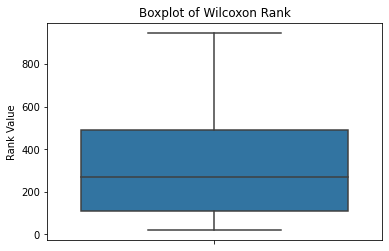

In [26]:
import seaborn as sns

sns.boxplot(y=baseline_rank)

# Add title and labels
plt.title("Boxplot of Wilcoxon Rank")
plt.ylabel("Rank Value")

# scGPT Embedding

In [27]:
from pathlib import Path

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
#import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [28]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="fibro", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model",
    model_name="best_model.pt",
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0, # DAR objective weight for batch correction
    mask_ratio=0.4, # Default mask ratio
    epochs=15, # Default number of epochs for fine-tuning
    n_bins=51, # Default number of bins for value binning in data pre-processing
    lr=1e-4, # Default learning rate for fine-tuning
    batch_size=64, # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
)
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

wandb: Currently logged in as: andrewhz-zhang. Use `wandb login --relogin` to force relogin


{'seed': 42, 'dataset_name': 'fibro', 'do_train': True, 'load_model': '/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model', 'model_name': 'best_model.pt', 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'mask_ratio': 0.4, 'epochs': 15, 'n_bins': 51, 'lr': 0.0001, 'batch_size': 64, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [29]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

dataset_name = config.dataset_name
save_dir = Path(f"/scratch/ssd004/scratch/ahz/perturb/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")

save to /scratch/ssd004/scratch/ahz/perturb/dev_fibro-Mar13-19-39


In [31]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / config.model_name
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var.index
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    print(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    print(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

match 954/1229 genes in vocabulary of size 60697.
Resume model from /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/best_model.pt, the model args will be overriden by the config /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/args.json.


In [39]:
# This step for binning
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=None,  # step 2
    normalize_total=None,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=None,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Binning data ...


In [40]:
genes = adata.var.index.tolist()
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)
adata.obs['batch_id'] = adata.obs['condition'].copy()
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
input_layer_key = "X_binned"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=False,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

In [41]:
model.eval()
adata_t = adata.copy()

In [44]:
adata

AnnData object with n_obs × n_vars = 83476 × 954
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage', 'gene_target', 'batch_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab'
    uns: 'hvg', 'log1p', 'wilcoxon'
    obsm: 'bin_edges'
    layers: 'X_binned'

In [45]:
all_counts = (
    adata_t.layers[input_layer_key].A
    if issparse(adata_t.layers[input_layer_key])
    else adata_t.layers[input_layer_key]
)
celltypes_labels = adata_t.obs["cell_line"].tolist()
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata_t.obs["batch_id"].tolist()
batch_ids = np.array(batch_ids)

tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=max_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

In [46]:
model.to(device)
wandb.watch(model)

with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
    gene_embeddings = model.encode_batch(
        all_gene_ids,
        all_values.float(),
        src_key_padding_mask=src_key_padding_mask,
        batch_size=config.batch_size,
        batch_labels=None,
        return_np=True,
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1305/1305 [08:13<00:00,  2.64it/s]


In [47]:
gene_embeddings.shape

(83476, 955, 512)

In [49]:
condition_ids = np.array(adata_t.obs["condition"].tolist())

In [50]:
condition_ids

array(['Irinotecan', 'Irinotecan', 'Irinotecan', ..., 'ctrl', 'ctrl',
       'ctrl'], dtype='<U28')

In [51]:
dict_sum_condition = {}
for i, c in enumerate(condition_ids):
    if c in dict_sum_condition:
        dict_sum_condition[c]+=gene_embeddings[i, :, :]
    else:
        dict_sum_condition[c]=gene_embeddings[i, :, :]

In [64]:
dict_sum_condition

{'Irinotecan': array([[  -75.608376,  1598.8278  ,   433.63812 , ...,    96.76154 ,
          -120.74786 ,   429.17065 ],
        [-1118.343   ,  1152.359   ,  1413.7582  , ...,   955.5118  ,
          -432.051   , -1527.7611  ],
        [ -359.18027 ,  1024.6224  ,   464.3838  , ...,   670.4485  ,
           104.91367 ,  -182.94014 ],
        ...,
        [ -642.5473  ,  1382.061   ,   169.32874 , ...,   967.307   ,
          -314.99146 ,    40.873142],
        [ -612.7693  ,  1121.8284  ,   610.2783  , ...,   515.186   ,
          -467.96222 ,  -393.03976 ],
        [ -479.58228 ,   537.57806 ,   367.87045 , ...,  1157.9993  ,
          -551.0083  ,  -532.63043 ]], dtype=float32),
 'Alpelisib': array([[ -170.38051  ,  1889.6472   ,   543.58636  , ...,   152.00046  ,
          -261.77637  ,   495.31927  ],
        [-1422.2404   ,  1416.558    ,  1773.8649   , ...,  1147.0747   ,
          -633.94916  , -1849.8033   ],
        [ -512.36945  ,  1238.5923   ,   492.41922  , ...,   853.44

In [52]:
dict_sum_condition_mean = {}
groups = adata_t.obs.groupby('condition').groups
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition[i]/len(groups[i])

In [53]:
dict_sum_condition_mean.keys()

dict_keys(['4EGI-1', '9-ING-41', 'AZD1390', 'AZD-7648', 'AZD-8055', 'Alpelisib', 'Anastrozole', 'Belzutifan', 'Bortezomib', 'Capmatinib', 'Celecoxib', 'ERK5-IN-2', 'EX229', 'Elimusertib hydrochloride', 'HI-TOPK-032', 'Irinotecan', 'Ixazomib', 'LY-2584702 (tosylate salt)', 'MK-3903', 'ML264', 'Methylprednisolone succinate', 'NVP-BHG712', 'OTS514', 'PF-06260933', 'PH-797804', 'Pralsetinib', 'RMC-6236', 'Sapanisertib', 'Sonidegib', 'TAK-733', 'TAK-901', 'Tucatinib', 'Vemurafenib', 'ctrl', 'venetoclax'])

In [67]:
dict_sum_target_gene_mean = {drug_target_map[drug] : dict_sum_condition_mean[drug] for drug in dict_sum_condition_mean.keys()}

In [79]:
def is_one_to_one_mapping(d):
    """
    Checks if a dictionary represents a one-to-one mapping.
    Returns True if it is, otherwise returns False and a dictionary
    of colliding values with their associated keys.
    """
    value_to_keys = {}
    collisions = {}
    
    for key, value in d.items():
        if value in value_to_keys:
            value_to_keys[value].append(key)
            collisions[value] = value_to_keys[value]
        else:
            value_to_keys[value] = [key]
    
    if collisions:
        return False, collisions
    return True, None

In [80]:
is_one_to_one_mapping(drug_target_map)

(False,
 {'PSMB5': ['Bortezomib', 'Ixazomib'],
  'PRKAA1': ['EX229', 'MK-3903'],
  'MTOR': ['AZD-8055', 'Sapanisertib']})

In [70]:
drug_target_map

{'4EGI-1': 'EIF4E',
 '9-ING-41': 'GSK3B',
 'Alpelisib': 'PIK3CA',
 'Anastrozole': 'CYP19A1',
 'AZD-7648': 'PRKDC',
 'AZD-8055': 'MTOR',
 'AZD1390': 'ATM',
 'Belzutifan': 'EPAS1',
 'Bortezomib': 'PSMB5',
 'Capmatinib': 'MET',
 'Celecoxib': 'PTGS2',
 'Elimusertib hydrochloride': 'ATR',
 'ERK5-IN-2': 'MAPK7',
 'EX229': 'PRKAA1',
 'HI-TOPK-032': 'PBK',
 'Irinotecan': 'TOP1',
 'Ixazomib': 'PSMB5',
 'LY-2584702 (tosylate salt)': 'RPS6KB1',
 'Methylprednisolone succinate': 'NR3C1',
 'MK-3903': 'PRKAA1',
 'ML264': 'KLF5',
 'NVP-BHG712': 'EPHB4',
 'OTS514': 'MAP3K8',
 'PF-06260933': 'MAP4K4',
 'PH-797804': 'MAPK14',
 'Pralsetinib': 'RET',
 'RMC-6236': 'KRAS',
 'Sapanisertib': 'MTOR',
 'Sonidegib': 'SMO',
 'TAK-733': 'MAP2K1',
 'TAK-901': 'AURKB',
 'Tucatinib': 'ERBB2',
 'Vemurafenib': 'BRAF',
 'venetoclax': 'BCL2',
 'ctrl': 'ctrl'}

In [69]:
dict_sum_condition_mean

{'4EGI-1': array([[-0.05578101,  0.6984398 ,  0.1943844 , ...,  0.04788631,
         -0.07160202,  0.18739575],
        [-0.52076125,  0.5120575 ,  0.6379962 , ...,  0.42785424,
         -0.20993298, -0.6798551 ],
        [-0.17077976,  0.45884198,  0.17378007, ...,  0.31101042,
          0.01466119, -0.07739034],
        ...,
        [-0.30606064,  0.6124947 ,  0.06760749, ...,  0.43505704,
         -0.1673753 ,  0.00951913],
        [-0.29812825,  0.5006408 ,  0.2671909 , ...,  0.23916896,
         -0.23481445, -0.17218162],
        [-0.24809864,  0.23551963,  0.19016486, ...,  0.52186596,
         -0.2651201 , -0.2374283 ]], dtype=float32),
 '9-ING-41': array([[-0.08946564,  0.6677251 ,  0.20743512, ...,  0.06365   ,
         -0.16355303,  0.19353232],
        [-0.55469406,  0.52791464,  0.68693745, ...,  0.406419  ,
         -0.28961498, -0.679803  ],
        [-0.22433358,  0.47199073,  0.13635252, ...,  0.31657428,
         -0.10245257, -0.07553123],
        ...,
        [-0.34807

In [74]:
len(dict_sum_condition_mean)

35

In [73]:
len(dict_sum_target_gene_mean)

32

In [68]:
dict_sum_target_gene_mean

{'EIF4E': array([[-0.05578101,  0.6984398 ,  0.1943844 , ...,  0.04788631,
         -0.07160202,  0.18739575],
        [-0.52076125,  0.5120575 ,  0.6379962 , ...,  0.42785424,
         -0.20993298, -0.6798551 ],
        [-0.17077976,  0.45884198,  0.17378007, ...,  0.31101042,
          0.01466119, -0.07739034],
        ...,
        [-0.30606064,  0.6124947 ,  0.06760749, ...,  0.43505704,
         -0.1673753 ,  0.00951913],
        [-0.29812825,  0.5006408 ,  0.2671909 , ...,  0.23916896,
         -0.23481445, -0.17218162],
        [-0.24809864,  0.23551963,  0.19016486, ...,  0.52186596,
         -0.2651201 , -0.2374283 ]], dtype=float32),
 'GSK3B': array([[-0.08946564,  0.6677251 ,  0.20743512, ...,  0.06365   ,
         -0.16355303,  0.19353232],
        [-0.55469406,  0.52791464,  0.68693745, ...,  0.406419  ,
         -0.28961498, -0.679803  ],
        [-0.22433358,  0.47199073,  0.13635252, ...,  0.31657428,
         -0.10245257, -0.07553123],
        ...,
        [-0.34807628,

In [71]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [76]:
perturb_targets = list(dict_sum_target_gene_mean.keys())

In [77]:
perturb_targets

['EIF4E',
 'GSK3B',
 'ATM',
 'PRKDC',
 'MTOR',
 'PIK3CA',
 'CYP19A1',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'MAPK7',
 'PRKAA1',
 'ATR',
 'PBK',
 'TOP1',
 'RPS6KB1',
 'KLF5',
 'NR3C1',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'ctrl',
 'BCL2']

In [78]:
condition_names_gene

['EIF4E',
 'GSK3B',
 'PIK3CA',
 'CYP19A1',
 'PRKDC',
 'MTOR',
 'ATM',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'ATR',
 'MAPK7',
 'PRKAA1',
 'PBK',
 'TOP1',
 'PSMB5',
 'RPS6KB1',
 'NR3C1',
 'PRKAA1',
 'KLF5',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'MTOR',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [81]:
perturb_targets.remove('ctrl')
assert 'ctrl' not in perturb_targets

In [83]:
dict_sum_target_gene_mean["ctrl"]

array([[-0.07025475,  0.6843736 ,  0.20153832, ...,  0.0553677 ,
        -0.10075139,  0.1782541 ],
       [-0.5229504 ,  0.5141912 ,  0.65597594, ...,  0.4224481 ,
        -0.2313697 , -0.67895186],
       [-0.18917646,  0.44795135,  0.17089133, ...,  0.31123823,
        -0.01906746, -0.0851078 ],
       ...,
       [-0.31724387,  0.6112235 ,  0.06484083, ...,  0.4404575 ,
        -0.1953694 ,  0.00429199],
       [-0.3159455 ,  0.50197846,  0.27312624, ...,  0.2516739 ,
        -0.2551571 , -0.17305282],
       [-0.27506104,  0.22924888,  0.22320868, ...,  0.52107865,
        -0.28721303, -0.2355073 ]], dtype=float32)

In [112]:
rank_list = []

for t in perturb_targets:
    celltype_0 = t
    celltype_1 = 'ctrl'
    gene_emb_celltype_0 = np.expand_dims(dict_sum_target_gene_mean[celltype_0][1:, :], 0)
    gene_emb_celltype_1 = np.expand_dims(dict_sum_target_gene_mean[celltype_1][1:, :], 0)
    gene_dist_dict = {}
    for i, 2048
    dd in tqdm(enumerate(genes)):
        gene_dist_dict[g] = cosine_distances(gene_emb_celltype_0[:, i, :], gene_emb_celltype_1[:, i, :]).mean()
    df_gene_emb_dist = pd.DataFrame.from_dict(gene_dist_dict, orient='index', columns=['cos_dist'])
    df_deg = df_gene_emb_dist.sort_values(by='cos_dist', ascending=False)
    print(t, np.where(df_deg.index==t)[0][0])
    rank_list.append(np.where(df_deg.index==t)[0][0])

954it [00:00, 3355.53it/s]


EIF4E 796


954it [00:00, 3144.42it/s]


GSK3B 162


954it [00:00, 3326.77it/s]


ATM 178


954it [00:00, 3186.20it/s]


PRKDC 344


954it [00:00, 3313.79it/s]


MTOR 283


954it [00:00, 3219.95it/s]


PIK3CA 204


954it [00:00, 3428.56it/s]


CYP19A1 290


954it [00:00, 3351.11it/s]


EPAS1 401


954it [00:00, 3172.00it/s]


PSMB5 952


954it [00:00, 3188.01it/s]


MET 83


954it [00:00, 3232.70it/s]


PTGS2 542


954it [00:00, 3383.94it/s]


MAPK7 944


954it [00:00, 3361.51it/s]


PRKAA1 461


954it [00:00, 3289.91it/s]


ATR 235


954it [00:00, 3269.21it/s]


PBK 836


954it [00:00, 3353.56it/s]


TOP1 505


954it [00:00, 3089.66it/s]


RPS6KB1 334


954it [00:00, 3552.02it/s]


KLF5 636


954it [00:00, 3259.47it/s]


NR3C1 297


954it [00:00, 3418.68it/s]


EPHB4 774


954it [00:00, 3367.15it/s]


MAP3K8 608


954it [00:00, 3328.57it/s]


MAP4K4 180


954it [00:00, 3217.82it/s]


MAPK14 253


954it [00:00, 3385.58it/s]


RET 785


954it [00:00, 3374.66it/s]


KRAS 859


954it [00:00, 3454.32it/s]


SMO 857


954it [00:00, 3457.15it/s]


MAP2K1 298


954it [00:00, 3259.55it/s]


AURKB 753


954it [00:00, 3550.79it/s]


ERBB2 658


954it [00:00, 3332.55it/s]


BRAF 310


954it [00:00, 3357.60it/s]

BCL2 198


## Save Results & Analysis

In [113]:
adata.uns['wilcoxon']['names']

rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
           ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
           ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C1', 'UBC', 'HES1', 'KYNU'),
           ...,
           ('VCL', 'EFNA5', 'MALAT1', 'IGFBP3', 'IGFBP3', 'IARS1', 'IGSF11', 'HSPA5', 'VCL', 'EGR1', 'PDE4D', 'IGFBP3', 'EGR1', 'H

In [114]:
perturb_targets

['EIF4E',
 'GSK3B',
 'ATM',
 'PRKDC',
 'MTOR',
 'PIK3CA',
 'CYP19A1',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'MAPK7',
 'PRKAA1',
 'ATR',
 'PBK',
 'TOP1',
 'RPS6KB1',
 'KLF5',
 'NR3C1',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [115]:
# rerun wilcoxon rank for gene targets instead

baseline_rank_t = []

for t in perturb_targets:
    # print(c)
    hvg_list = adata.uns['wilcoxon']['names'][t]
    p_val = adata.uns['wilcoxon']['pvals_adj'][t]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(t, np.where(df_gene_emb_dist.gene.values==t)[0][0])
    baseline_rank_t.append(np.where(df_gene_emb_dist.gene.values==t)[0][0])

EIF4E 330
GSK3B 37
ATM 65
PRKDC 519
MTOR 370
PIK3CA 313
CYP19A1 770
EPAS1 54
PSMB5 342
MET 212
PTGS2 33
MAPK7 490
PRKAA1 269
ATR 200
PBK 228
TOP1 63
RPS6KB1 171
KLF5 56
NR3C1 107
EPHB4 594
MAP3K8 483
MAP4K4 19
MAPK14 268
RET 549
KRAS 146
SMO 566
MAP2K1 42
AURKB 849
ERBB2 591
BRAF 125
BCL2 946


In [116]:
baseline_rank_t

[330,
 37,
 65,
 519,
 370,
 313,
 770,
 54,
 342,
 212,
 33,
 490,
 269,
 200,
 228,
 63,
 171,
 56,
 107,
 594,
 483,
 19,
 268,
 549,
 146,
 566,
 42,
 849,
 591,
 125,
 946]

In [117]:
perturb_targets

['EIF4E',
 'GSK3B',
 'ATM',
 'PRKDC',
 'MTOR',
 'PIK3CA',
 'CYP19A1',
 'EPAS1',
 'PSMB5',
 'MET',
 'PTGS2',
 'MAPK7',
 'PRKAA1',
 'ATR',
 'PBK',
 'TOP1',
 'RPS6KB1',
 'KLF5',
 'NR3C1',
 'EPHB4',
 'MAP3K8',
 'MAP4K4',
 'MAPK14',
 'RET',
 'KRAS',
 'SMO',
 'MAP2K1',
 'AURKB',
 'ERBB2',
 'BRAF',
 'BCL2']

In [118]:
len(perturb_targets)

31

In [119]:
len(baseline_rank_t)

31

In [120]:
len(rank_list)

31

In [121]:
df_results = df = pd.DataFrame({
    'conditions': perturb_targets,
    'wilcoxon': baseline_rank_t,
    'scGPT_rank': rank_list
})

In [122]:
df_results

,conditions,wilcoxon,scGPT_rank
0,EIF4E,330,796
1,GSK3B,37,162
2,ATM,65,178
3,PRKDC,519,344
4,MTOR,370,283
5,PIK3CA,313,204
6,CYP19A1,770,290
7,EPAS1,54,401
8,PSMB5,342,952
9,MET,212,83


In [123]:
df_results.mean()

wilcoxon      316.354839
scGPT_rank    484.387097
dtype: float64

In [124]:
df_results.to_csv('/scratch/ssd004/scratch/ahz/perturb/vevo_tahoe_ranks_Mar13.csv')

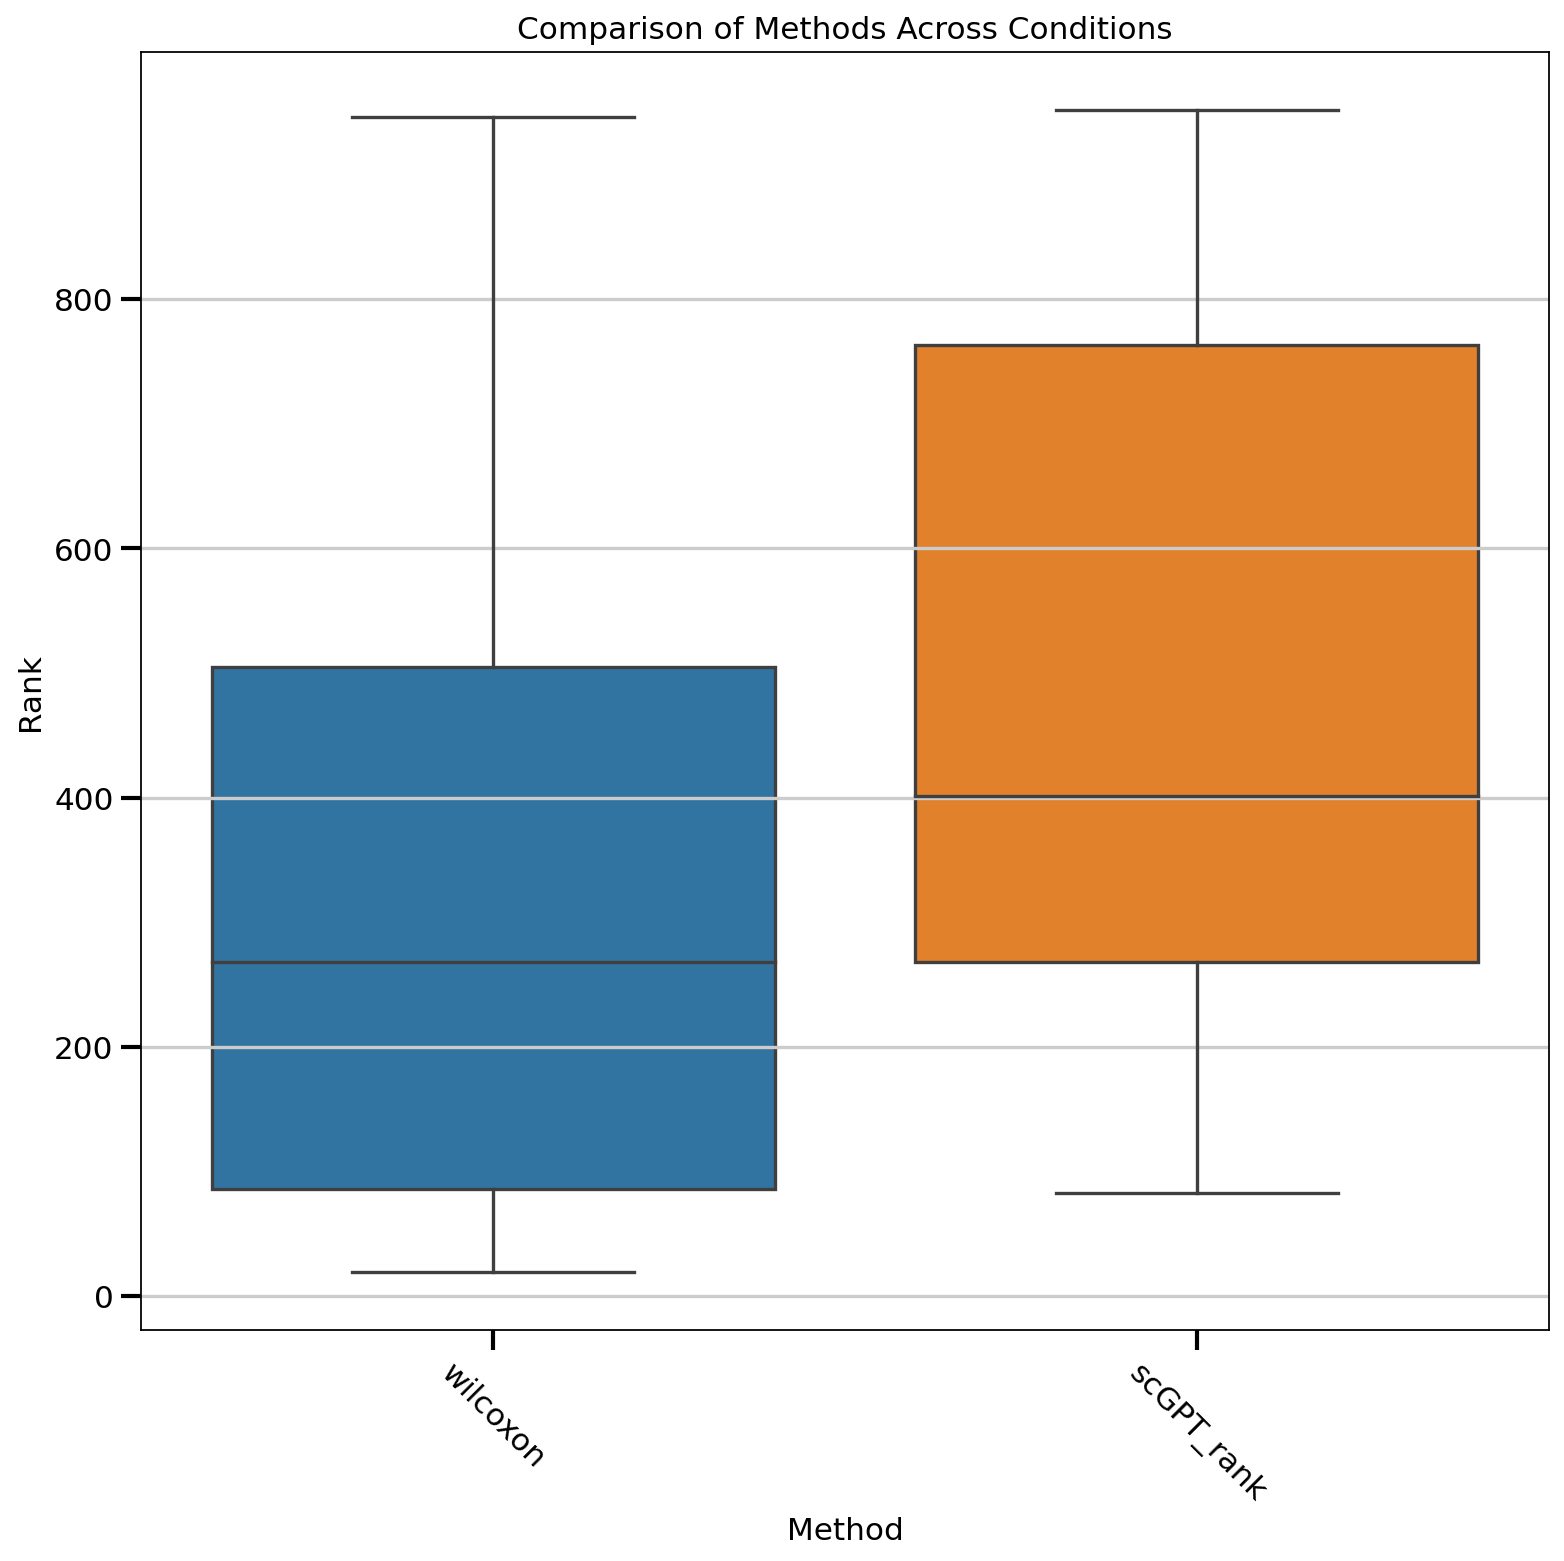

In [126]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_results)

# Add titles and labels
plt.title('Comparison of Methods Across Conditions')
plt.xlabel('Method')
plt.ylabel('Rank')
plt.xticks(rotation=-45)
# plt.yscale('log')
# Display the plot
plt.tight_layout()

plt.legend([],[], frameon=False)

<AxesSubplot:xlabel='wilcoxon', ylabel='scGPT_rank'>

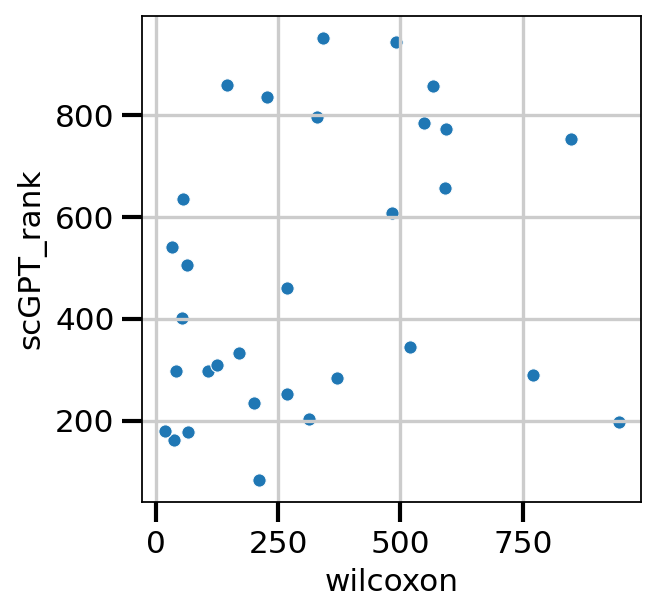

In [127]:
sns.scatterplot(data=df_results, x="wilcoxon", y="scGPT_rank")

In [128]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(df_results['wilcoxon'], df_results['scGPT_rank'])

print(f'Pearson Correlation: {corr}, p-value: {p_value}')

Pearson Correlation: 0.283193885139967, p-value: 0.12264674342302984
